<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Задачи" data-toc-modified-id="Задачи-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Задачи</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка данных</a></span><ul class="toc-item"><li><span><a href="#Пропуски-и-дубликаты" data-toc-modified-id="Пропуски-и-дубликаты-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Пропуски и дубликаты</a></span></li><li><span><a href="#Пересечение-между-группами" data-toc-modified-id="Пересечение-между-группами-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Пересечение между группами</a></span></li></ul></li><li><span><a href="#A/A-тестирование" data-toc-modified-id="A/A-тестирование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>A/A тестирование</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#A/B-тестирование" data-toc-modified-id="A/B-тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>A/B тестирование</a></span><ul class="toc-item"><li><span><a href="#Проверка-гипотезы" data-toc-modified-id="Проверка-гипотезы-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Проверка гипотезы</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li></ul></div>

# A/A и A/B тестирование с помощью bootstrap

Обучающая платформа EdTex, где пользователи могут покупать подписку и проходить обучающие курсы как в видео, так и в текстовом формате. Отделом аналитики была выдвинута гипотеза, что стандартный видеоплеер в мобильном приложении платформы работает плохо, что может вызывать отток клиентов.

Отделом разработки был интегрирован более новый видеоплеер. Теперь нам предстоит удостовериться, что новый видеоплеер положительно повлияет на лояльность пользователей. Для этого были сформированы выборки для A/A и A/B тестирования. В качестве целевого показателя решено использовать медианную продолжительность сессий пользователей в мобильном приложении.

## Задачи

- Проведение A/A теста
- Проверка гипотезы о значимой разнице медианной продолжительности сессий, в A B выборках

## Предобработка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm

plt.style.use('bmh')

In [2]:
df = pd.read_csv('./total_duration.csv', index_col=0)

In [3]:
df.head()

,user_id,group,total_duration
0,793186,control1,1931.068973
1,3472516,treatment,220.892637
2,3375424,treatment,16.126804
3,3791823,treatment,4708.597091
4,421235,control1,713.280479


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3964936 entries, 0 to 3964935
Data columns (total 3 columns):
 #   Column          Dtype  
---  ------          -----  
 0   user_id         int64  
 1   group           object 
 2   total_duration  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 121.0+ MB


- Всего около 4 млн наблюдений
- Типы данных соответствуют смыслу переменных

### Пропуски и дубликаты

In [5]:
df.isna().sum()

user_id           0
group             0
total_duration    0
dtype: int64

In [6]:
df.duplicated().sum()

0

Пропуски и дубликаты отсутствуют

### Пересечение между группами

Посмотрим, есть ли пользователи которые попали сразу в разные группы

In [7]:
df['user_id'].duplicated().sum()

0

Дубликаты среди `user_id` отсутствуют, значит и пересечений нет

## A/A тестирование

Чтобы убедиться в том, что инструмент разделения пользователей на выборки сработал корректно, нам нужно провести тестирование между группами `control1` и `control2`, на которые не оказывались никакие экспериментальные воздействия и если разницы между этими группами не обнаружится, значит сплит сработал успешно

Для начала визуально посмотрим, видна ли разница между группами

In [8]:
a1 = df[df['group'] == 'control1']['total_duration']
a2 = df[df['group'] == 'control2']['total_duration']

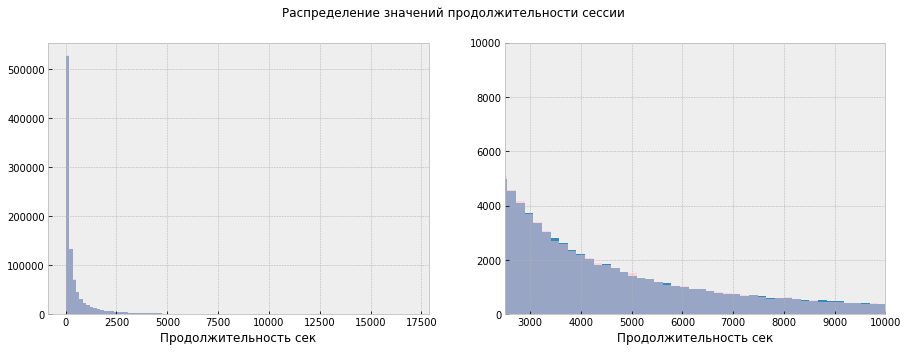

In [9]:
plt.figure(figsize=(15, 5))
plt.suptitle('Распределение значений продолжительности сессии')

plt.subplot(1,2,1)
plt.hist(a1, bins=100)
plt.hist(a2, bins=100, alpha=0.5, color='pink')
plt.xlabel('Продолжительность сек')

plt.subplot(1,2,2)
plt.hist(a1, bins=100)
plt.hist(a2, bins=100, alpha=0.5, color='pink')
plt.ylim(0, 10000)
plt.xlim(2500, 10000)
plt.xlabel('Продолжительность сек')

plt.show()

Визуально, выборки очень похожи. Проведем множество экспериментов с помощью бутстреп выборок и посмотрим на распределение p-value. Напишем функцию

In [10]:
def test_pvalues_distribution(a, b, n_iter, sample_size, alpha, test):
    p_values = []
    for i in tqdm(range(n_iter)):
        a1_sample = np.random.choice(a1, size=sample_size, replace=True)
        a2_sample = np.random.choice(a2, size=sample_size, replace=True)
        pvalue = test(a1_sample, a2_sample).pvalue
        p_values.append(pvalue)
    plt.hist(p_values)
    plt.show()
    print((pd.Series(p_values) < alpha).mean())

Зададим параметры тестирования

In [11]:
n_iter = 10000
sample_size = 1000
alpha = 0.05

Запустим тест, стат критерием при этом выберем t-тест

100%|██████████| 10000/10000 [00:03<00:00, 2792.08it/s]


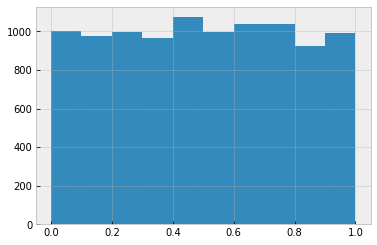

0.0496


In [12]:
test_pvalues_distribution(
    a1, 
    a2, 
    n_iter, 
    sample_size,
    alpha,
    lambda a, b: stats.ttest_ind(a, b, equal_var=False)
)

Распределение значений p-value по результатам множества t-тестов похоже на равномерное, не смотря на то, что не соблюдается допущение о нормальном распределении генеральной совокупности. Проделаем те же шаги, но с непараметрическим тестом Манна-Уитни

100%|██████████| 10000/10000 [00:20<00:00, 499.38it/s]


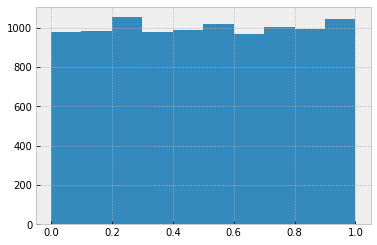

0.0487


In [13]:
test_pvalues_distribution(
    a1, 
    a2, 
    n_iter, 
    sample_size,
    alpha,
    stats.mannwhitneyu
)

Распределение значений p-value также похоже на равномерное

### Вывод
По результатам A/A тестирования мы можем полагать, что инструмент разделения пользователей на группы сработал успешно

## A/B тестирование

Для дальнейшего исследования объединим группы control1, control2 в одну группу

In [14]:
df['group'] = df['group'].map({
    'control1': 'control', 
    'control2': 'control', 
    'treatment': 'treatment'
})

In [15]:
df['group'].value_counts()

control      1982468
treatment    1982468
Name: group, dtype: int64

Группы сбалансированы. Теперь посмотрим на распределения общей продолжительности пользования приложения по группам

In [16]:
a = df[df['group'] == 'control']['total_duration']
b = df[df['group'] == 'treatment']['total_duration']

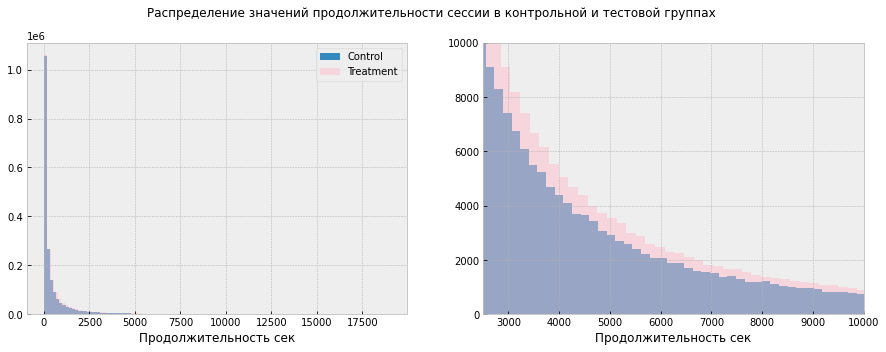

In [17]:
plt.figure(figsize=(15, 5))
plt.suptitle('Распределение значений продолжительности сессии в контрольной и тестовой группах')
plt.subplot(1,2,1)
plt.hist(a, bins=100, label='Control')
plt.hist(b, bins=100, alpha=0.5, color='pink', label='Treatment')
plt.xlabel('Продолжительность сек')
plt.legend()

plt.subplot(1,2,2)
plt.hist(a, bins=100, label='Control')
plt.hist(b, bins=100, alpha=0.5, color='pink', label='Treatment')
plt.ylim(0, 10000)
plt.xlim(2500, 10000)
plt.xlabel('Продолжительность сек')

plt.show()

In [18]:
df.groupby('group').agg({'total_duration': ['mean', 'median']})

total_duration            
                    mean      median
group                               
control       713.496899  145.050117
treatment     790.519165  160.792156

In [19]:
print('uplift:', round((b.median() - a.median()) / a.median() * 100, 2))

uplift: 10.85


- Средняя и медианная общая продолжительность сессий больше в тестовой группе
- Медианная продолжительность в тестовой группе больше почти на 11%

Проведем тестирование, чтобы узнать является ли эта разница значимой

### Проверка гипотезы

$H_{0}: M_{A} = M_{B}$  
$H_{1}: M_{A} \neq M_{B}$

**Основная (нулевая) гипотеза** - медианная продолжительность контрольной и тестовой группы не имеют статистически значимых различий;
**Альтернативная гипотеза** - медианная продолжительность контрольной и тестовой группы имеют статистически значимые различия.

Наша целевая метрика это медиана - значит в качестве статистического критерия нам придется использовать Бутстреп, так как центральная предельная теорема не позволяет строить доверительные интервалы для медианы

Объявим уровень значимости в 5%

In [20]:
alpha = 0.05
conf_level = 1 - alpha

Напишем функцию для формирования бут-выборок и построения графика с доверительными интервалами

In [21]:
def get_bootstrap(a,  b, sample_size, n_iter=1000, statistic=np.median):
    boot_data = []
    for i in tqdm(range(n_iter)): 
        sample_1 = np.random.choice(a, sample_size, replace=True)
        sample_2 = np.random.choice(b, sample_size, replace=True)
        boot_data.append(statistic(sample_1 - sample_2))

    left_quant = alpha / 2
    right_quant = 1 - alpha / 2
    quants = np.quantile(boot_data, [left_quant, right_quant])

    p_1 = stats.norm.cdf(x=0, loc=np.mean(boot_data), scale=np.std(boot_data))
    p_2 = stats.norm.cdf(x=0, loc=-np.mean(boot_data), scale=np.std(boot_data))
    p_value = min(p_1, p_2) * 2

    plt.figure(figsize=(10, 5))
    _, _, bars = plt.hist(boot_data, bins=50)
    for bar in bars:
        if bar.get_x() <= quants[0] or bar.get_x() >= quants[1]:
            bar.set_facecolor('red')
        else:
            bar.set_facecolor('lightblue')
            bar.set_edgecolor('black')

    plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('Разница медианной продолжительности')
    plt.ylabel('Частота')
    plt.title('Распределение разницы медианной продолжительности')
    plt.show()

    return {"boot_data": boot_data,
            "quants": quants,
            "p_value": p_value}

Размер бут-выборок установим как максимальное из двух размеров A B выборок.

In [22]:
sample_size = max([len(a), len(b)])
sample_size

1982468

Проведем тест

100%|██████████| 1000/1000 [01:25<00:00, 11.74it/s]


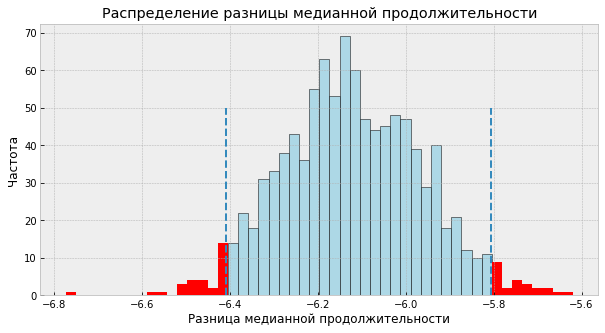

In [23]:
result = get_bootstrap(a, b, sample_size)

In [24]:
result['p_value']

0.0

### Вывод
В пределах 95%-го доверительного интервала значения 0 не оказалось, значит у нас есть основания полагать, что в тестовой группе B, медианная продолжительность значительно больше, чем в группе A